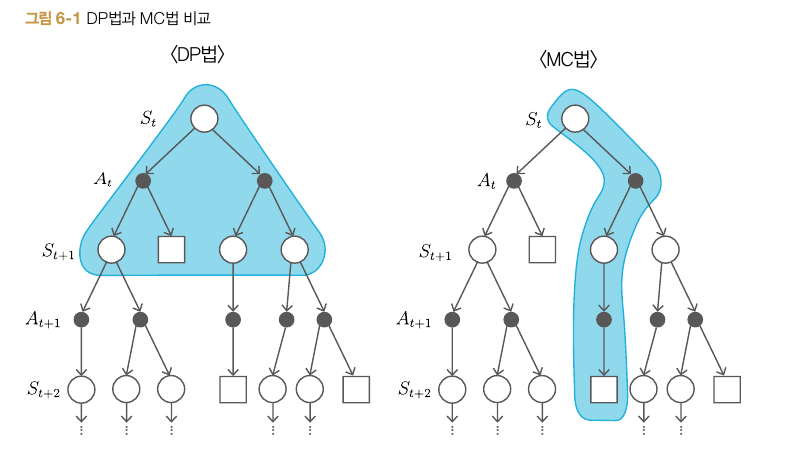

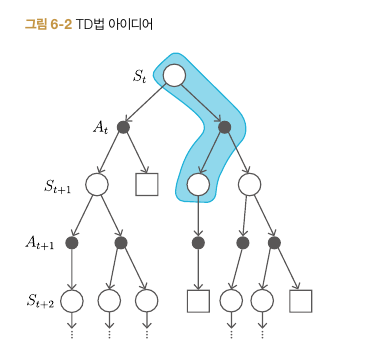

- DP(dynamic process) : 
    * 모든 전이를 고려
    * bootstrap : 다음가치함수의 추정치를 이용하여 현재 가치함수의 추정치 갱신
    </br></br>


- MC(monte carlo) : 실제 얻은 일부 경험만을 토대로 현재가치함수 갱신(에피소드가 길면 시간이 오래 걸리고 countinuous task 에는 사용 불가한 단점)
</br></br>

- TD(temperal difference) : 에피소드가 끝날 때까지 기다리지 않고 일정 시간마다 정책 평가 및 개선
    * DP와 같이 bootstrap 사용해 가치함수를 순차적 갱신
    * MC와 같이 환경에 대한 정보 없이 샘플린된 데이터 만으로 가치함수 갱신 
</br></br>
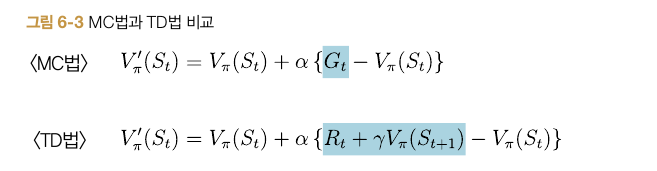

# TD_eval

In [11]:
from collections import defaultdict, deque
import numpy as np
from gridworld import GridWorld
from utils import greedy_probs

In [3]:
class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]  # 목표 지점의 가치 함수는 0
        target = reward + self.gamma * next_V
        self.V[state] += (target - self.V[state]) * self.alpha


In [4]:
env = GridWorld()
agent = TdAgent()

In [5]:
episodes = 1000

In [6]:
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.eval(state, reward, next_state, done)  # 매번 호출
        if done:
            break
        state = next_state

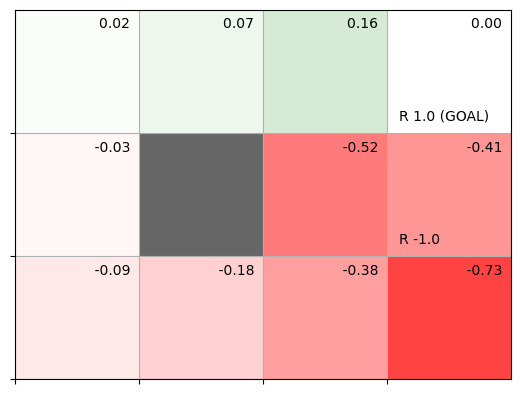

In [7]:
# [그림 6-5] TD법으로 얻은 가치 함수
env.render_v(agent.V)

# SARSA

In [12]:
class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)  # deque 사용

    def get_action(self, state):
        action_probs = self.pi[state]  # pi에서 선택
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        next_q = 0 if done else self.Q[next_state, next_action]  # 다음 Q 함수

        # TD법으로 self.Q 갱신
        target = reward + self.gamma * next_q
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        
        # 정책 개선
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

- deque : 리스트와 비슷하게 사용, 지정된 최대 원소수(=maxlen)을 초과하여 원소가 추가되면 선입선출에 따라 가장 오래된 원소 삭제.
- on policy 하나만 사용
- target에서의 Q func는 0 (Q func는 미래에서 얻을 수 있는 보상의 총합인데,target에 도달하면 더 받을 수 없기 때문)

In [13]:
env = GridWorld()
agent = SarsaAgent()

In [14]:
episodes = 10000

In [15]:
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)  # 매번 호출

        if done:
            # 목표에 도달했을 때도 호출
            agent.update(next_state, None, None, None)
            break
        state = next_state

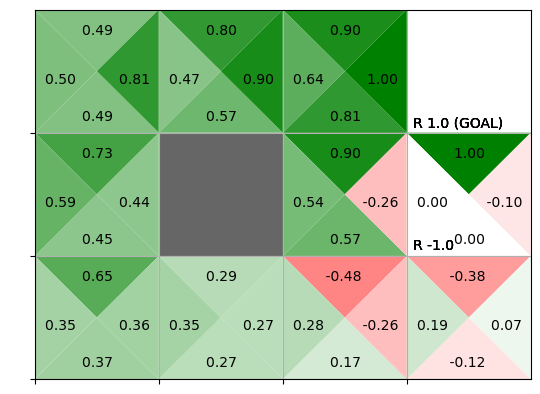

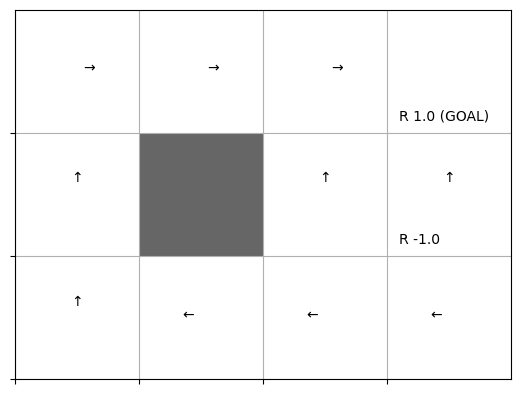

In [16]:
# [그림 6-7] SARSA로 얻은 결과
env.render_q(agent.Q)

# SARSA off policy

In [18]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.b[state]  # 행동 정책에서 가져옴
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]

        if done:
            next_q = 0
            rho = 1
        else:
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]  # 가중치 rho 계산

        # rho로 TD 목표 보정
        target = rho * (reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        # 각각의 정책 개선
        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

In [19]:
env = GridWorld()
agent = SarsaOffPolicyAgent()

In [20]:
episodes = 10000

In [21]:
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

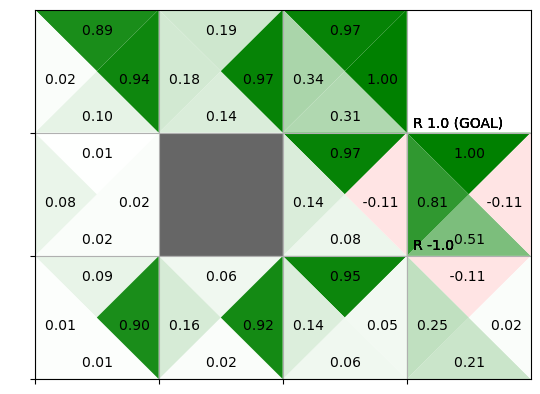

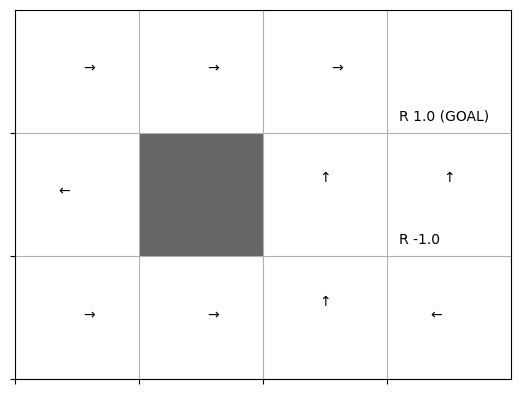

In [22]:
# [그림 6-9] 오프-정책 SARSA로 얻은 결과
env.render_q(agent.Q)

# Q-learning

- off policy sarsa는 action policy 와 target policy 가 다름
    - action policy는 "탐색", target policy 는 "활용"
- 이때, 중요도 샘플링은 결과가 불안정하기 쉽다는 문제를 가지고 있음
    - 두 정책의 확률 분포가 다를수록 중요도 샘플링에서 사용하는 가중치 $\rho$ 의 변동성이 커짐
- 따라서 SARSA의 갱신식에 등장하는 목표 역시 변동되어 Q func 갱신이 불안정

- Q-learning
    * TD
    * off policy
    * 중요도 샘플링 안함
    

In [23]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)  # 행동 정책
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.b[state]  # 행동 정책에서 가져옴
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:  # 목표에 도달
            next_q_max = 0
        else:     # 그 외에는 다음 상태에서 Q 함수의 최댓값 계산
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        # Q 함수 갱신
        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        # 행동 정책과 대상 정책 갱신
        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)


In [24]:
env = GridWorld()
agent = QLearningAgent()

In [25]:
episodes = 10000

In [26]:
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state


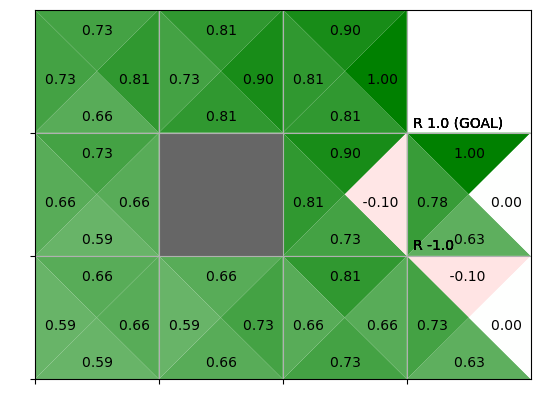

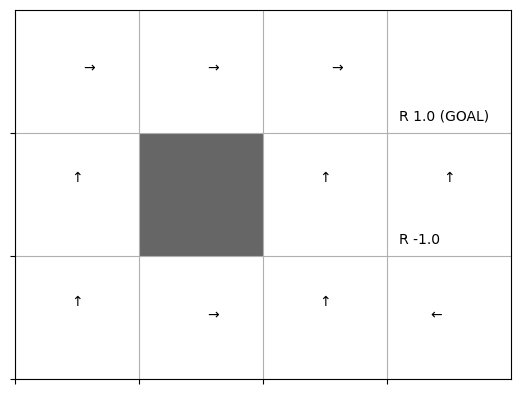

In [27]:
# [그림 6-15] Q 러닝으로 얻은 Q 함수와 정책
env.render_q(agent.Q)

# Q-learning simple

In [28]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:  # epsilon의 확률로 무작위 행동
            return np.random.choice(self.action_size)
        else:                                # (1 - epsilon)의 확률로 탐욕 행동
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha


In [29]:
env = GridWorld()
agent = QLearningAgent()

In [30]:
episodes = 1000

In [31]:
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

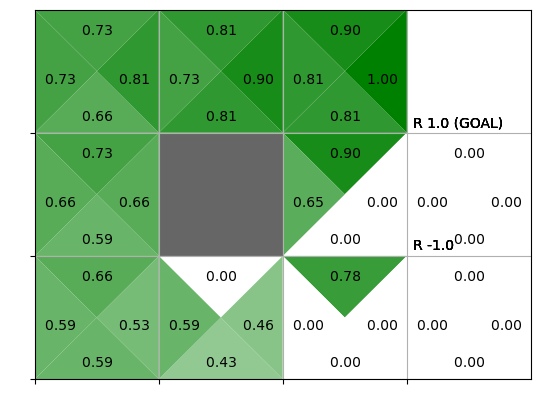

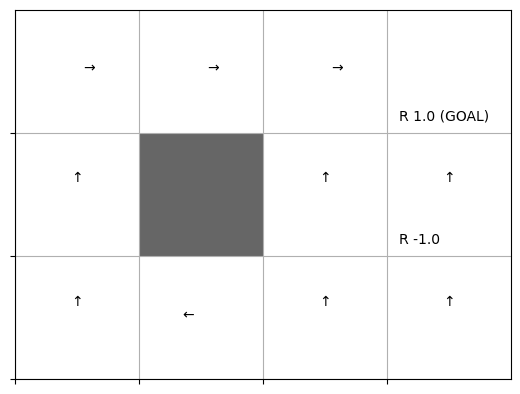

In [32]:
env.render_q(agent.Q)